# Predictive maintenance
The goal is to calculate the RUL of the engines by using ML techniques. 

## Structure
- Read data
- feature engineering
- regression
- classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KN

from timeit import default_timer as timer   # for measuring computation time
from pympler import asizeof                 # for measuring ML object size

# import self defined functions
from add_remaining_useful_life import add_remaining_useful_life
from plot_sensor_signal import plot_sensor_signal
from evaluate import evaluate
from plot_sensor_std import plot_sensor_std


In [2]:
dir_path = './input/'
train_file = 'PM_train.txt'
train_location = dir_path + train_file
test_file = 'PM_test.txt'
test_location = dir_path + test_file
truth_file = 'PM_truth.txt'
truth_location = dir_path + truth_file

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['s{}'.format(i+1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(train_location, sep='\s+', header=None, names=col_names)    # s+ -> regex for spaces/tabs as spaces
test = pd.read_csv(test_location, sep='\s+', header=None, names=col_names)
y_test = pd.read_csv(truth_location, sep='\s+', header=None, names=['RUL'])

print(train.shape)

(20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [3]:
# inspect cycles of train data
train[index_names].groupby('id').max().describe()

,cycle
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [4]:
# checking sensor data
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


Some sensor values have a standard deviation = 0, such as s1, s5, s16, s18, s19. Having a standard deviation of zero means that there these features are stationary thus not changing over time. 
Such sensor values are irrelevant when determining the RUL.  

In [5]:
# Computation of RUL
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)
train[index_names+['RUL']].head()

,id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [6]:
print(y_test['RUL'][0])
print(test['RUL'][200])

for i in range(len(test)):
    currentID = test['id'][i]
    current_truth_value = y_test['RUL'][currentID - 1]
    test['RUL'][i] = test['RUL'][i] + current_truth_value


112
5


After calculating the RUL, we check the distribution of the RULs. This will give a rough idea how often different RULs are present. 

Text(0, 0.5, 'frequency')

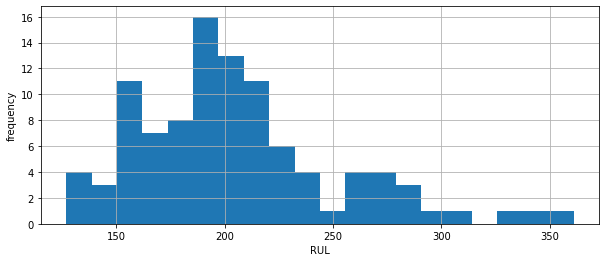

In [7]:
df_max_rul = train['id RUL'.split(' ')].groupby('id').max().reset_index()
df_max_rul['RUL'].hist(bins=20, figsize=(10, 4))
plt.xlabel('RUL')
plt.ylabel('frequency')

With the distribution we can see, that the RUL ofter lies in 200 cycles. The distribution has roughly a normal distribution with some extreme values.  

## Plotting signal values
In order to get an idea, how different sensor values affect the RUL, those sensor signal values are plotted against the RUL values. 
Each plot shows the sensor value plotted against the RUL by using 5 different time series in each id.  

In [8]:
for sensor_value in sensor_names:
    #plot_sensor_signal(train, sensor_value)
    pass

As seen in the plots above, some sensor signals have a slight decrease in sensor value when approaching 0 RUL, while others show an increase. 
There are also signals, which are just straight lines. These can be deemed irrelevant for the model. 
Therefore, we define a list of unwanted sensor signals which will later be dropped from the training set. 

In [9]:
# plot std
# plot_sensor_std(train)

In [10]:
drop_sensors = 's1 s5 s6 s10 s16 s18 s19'.split(' ')
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = 's2 s3 s4 s7 s8 s9 s11 s12 s13 s14 s15 s17 s20 s21'.split(' ')

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
X_test = test.groupby('id').last().reset_index().drop(drop_labels, axis=1)
X_test = X_test.drop('RUL', axis=1)

# Regression models
The first approach is using regression models as means to solve this problem. By using regression, the RUL can be estimated or predicted. 

## Baseline model as reference
In order to be able to assess the improvement or the superiority of a ML model a baseline model with simple linear regression is used. 

In [11]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')
print('len y_train: ' + str(len(y_train)))
print('len y_test: ' + str(len(y_test)))

y_hat_test = lm.predict(X_test)
rsme_reg = evaluate(y_test, y_hat_test)

# calculate relative error
y_test_array = np.array(y_test['RUL'])
x = y_hat_test - y_test_array
error_re_y_test_reg = abs(100 * (x/y_test_array))

train set RMSE:44.6681915954545, R2:0.5794486527796721
len y_train: 20631
len y_test: 100
test set RMSE:31.952633027739893, R2:0.4087736807658121


## Random Forest model
In order to increase the accuracy of the baseline model the Random Forest model is implemented. 

In [12]:
rf = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=42, max_depth=10, min_samples_leaf=50)  # depth should be less than number of features

# fit model + measure computation time
start = timer()
rf.fit(X_train, y_train)
end = timer()
time = end - start
print('Time for training of Random Forest Model: ' + str(round(time, 2)) + 's. ')   
rf_size = asizeof.asizeof(rf)
print('Memory allocation of Random Forest object: ' + str(rf_size/1e6) + 'MB')

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
rsme_rf = evaluate(y_test, y_hat_test)        # y_test = ideal solution, while y_hat_test = predicted solution

# calculate relative error 
y_test_array = np.array(y_test['RUL'])
x = y_hat_test - y_test_array
error_re_y_test_rf = abs(100 * (x/y_test_array))

Time for training of Random Forest Model: 12.81s. 
Memory allocation of Random Forest object: 0.255912MB
train set RMSE:39.931480443512434, R2:0.6639119185439148
test set RMSE:30.42435900934061, R2:0.46397711724773816


## Support Vector Machine
Another ML technique is SVM. This can be used for both classification and regression problems. 

In [13]:
# scale data
sc = MinMaxScaler()
# use transformations: standardisierung
# multiple training runs: with batches (init model with previous)
# use bins for RUL -> could be better, easier for model
# PCA 
# calculate error for each RUL-value: should decrease each cycle

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

# fit
svr = SVR(kernel='rbf', C=0.035, gamma=0.5, degree=3, epsilon=.5, coef0=1)
svr.fit(X_train_sc, y_train)

# predict
y_hat_train = svr.predict(X_train_sc)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_sc)
rsme_svr = evaluate(y_test, y_hat_test, 'test')

# calculate relative error 
y_test_array = np.array(y_test['RUL'])
x = y_hat_test - y_test_array
error_re_y_test_svr = abs(100 * (x/y_test_array))

train set RMSE:50.424189026555545, R2:0.46407979325633797
test set RMSE:22.45924205924393, R2:0.7079006116757677


# LSTM regression model

In [22]:
# scaling
train[remaining_sensors]=sc.fit_transform(train[remaining_sensors])
test[remaining_sensors]=sc.transform(test[remaining_sensors])

#to predict with regression
target_col_name_reg = 'RUL'

# generate X_train
X_train = np.array(train[remaining_sensors])

#generate y_train regression
Y_train_reg = train[target_col_name_reg]

# generate X_test
X_test = np.array(test[remaining_sensors])

#generate y_test regression
Y_test_reg = test[target_col_name_reg]


In [23]:
#generate training dataset for LMST
sequence = 50
X_train_LSTM = np.zeros((X_train.shape[0]-sequence,sequence, X_train.shape[1])) #start matrix
id_train = np.reshape(np.array(train['id']),((X_train.shape[0],1)))
X_train_help = np.hstack((id_train, X_train)) #add id in trainings set

for i in range (sequence, X_train.shape[0]-1):          # row (cycle)
    for k in range (0, sequence -1):                    # column (old sensor values)
           for j in range (0, X_train_help.shape[1]-1): # column sekound dimension (sensor values)
                if X_train_help[i-k, 0] - X_train_help[i, 0] >= 0:
                    X_train_LSTM[i-sequence, k, j] = X_train_help[i-k, j+1] #overwrite values

#generate Y train for LMST with same shape
Y_train_LSTM = np.zeros((Y_train_reg.shape[0] - sequence))

for i in range (sequence, Y_train_reg.shape[0]-1): 
    Y_train_LSTM [i-sequence] = Y_train_reg [i]

#generate testing dataset for LMST
X_test_LSTM = np.zeros((X_test.shape[0], sequence, X_test.shape[1]))
id_test = np.reshape(np.array(test['id']),((X_test.shape[0],1)))
X_test_help = np.hstack((id_test, X_test)) #add id in test set

for i in range (0, X_test.shape[0]-1):                 # row (cycle)
    for k in range (0, sequence -1):                   # column (old sensor values)
           for j in range (0, X_test_help.shape[1]-1):        # column sekound dimension (sensor values)
                if i - k >= 0:
                    if X_test_help[i-k, 0] - X_test_help[i, 0] >= 0:
                        X_test_LSTM[i, k, j] = X_test_help[i-k, j+1] #overwrite values
                        
np.shape(X_test_LSTM)

(13096, 50, 14)

In [24]:
nb_features = X_train_LSTM.shape[2]
timestamp=sequence

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           46000     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 76,251
Trainable params: 76,251
Non-trainable params: 0
_________________________________________________________________


In [25]:
Y_train_LSTM_reg = np.zeros((Y_train_reg.shape[0] - sequence))

for i in range (sequence, Y_train_reg.shape[0]-1): 
    Y_train_LSTM_reg [i-sequence] = Y_train_reg [i]
    
# fit the network
model.fit(X_train_LSTM, Y_train_LSTM_reg, epochs=20, batch_size=200, validation_split=0.05, verbose=1)
#callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')]

Epoch 1/20
98/98 [==============================] - 17s 173ms/step - loss: -1071.2134 - accuracy: 0.0049 - val_loss: -1502.9066 - val_accuracy: 0.0049
Epoch 2/20
98/98 [==============================] - 17s 169ms/step - loss: -1790.4828 - accuracy: 0.0049 - val_loss: -2061.1567 - val_accuracy: 0.0049
Epoch 3/20
98/98 [==============================] - 16s 163ms/step - loss: -2342.3284 - accuracy: 0.0049 - val_loss: -2600.8333 - val_accuracy: 0.0049
Epoch 4/20
98/98 [==============================] - 15s 155ms/step - loss: -2877.9895 - accuracy: 0.0049 - val_loss: -3133.5693 - val_accuracy: 0.0049
Epoch 5/20
98/98 [==============================] - 15s 156ms/step - loss: -3413.0049 - accuracy: 0.0049 - val_loss: -3661.8865 - val_accuracy: 0.0049
Epoch 6/20
98/98 [==============================] - 17s 173ms/step - loss: -3944.3342 - accuracy: 0.0049 - val_loss: -4188.8481 - val_accuracy: 0.0049
Epoch 7/20
98/98 [==============================] - 17s 173ms/step - loss: -4467.0879 - accura

In [28]:
Y_pred_LSTM_reg=model.predict(X_test_LSTM)

scores_reg = model.evaluate(X_train_LSTM, Y_train_LSTM_reg, verbose=1, batch_size=200)

103/103 [==============================] - 5s 52ms/step - loss: -11547.8096 - accuracy: 0.0049


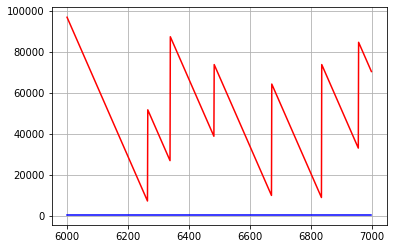

In [32]:
t = np.arange(0, Y_pred_LSTM_reg.shape[0])

#Ausschnitt
a = 6000
e = 7000

plt.plot(t[a:e], Y_pred_LSTM_reg[a:e]*340, 'b')
plt.plot(t[a:e], Y_test_reg[a:e]*340, 'r')
plt.grid(True)

## Comparison of predicted results
Next, we evaluate the predicted results. 

No handles with labels found to put in legend.


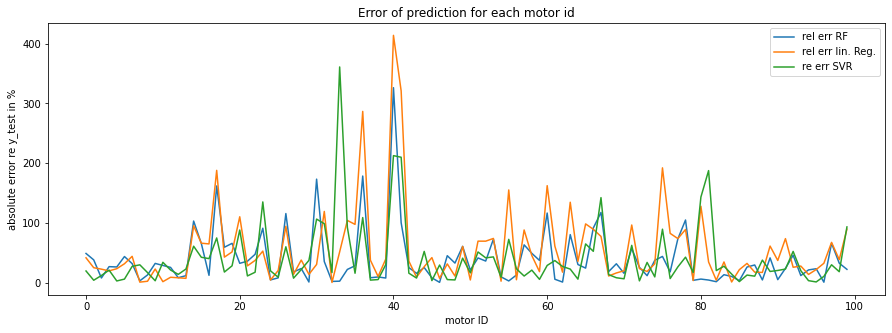

In [164]:
# plotting data

plt.figure(figsize=(15, 5))

plt.title('Error of prediction for each motor id')
plt.legend(loc='upper right')

plt.plot(error_re_y_test_rf)
plt.plot(error_re_y_test_reg)
plt.plot(error_re_y_test_svr)
plt.xlabel("motor ID")
plt.ylabel('absolute error re y_test in %')
plt.gca().legend(('rel err RF','rel err lin. Reg.', 're err SVR'))


No handles with labels found to put in legend.


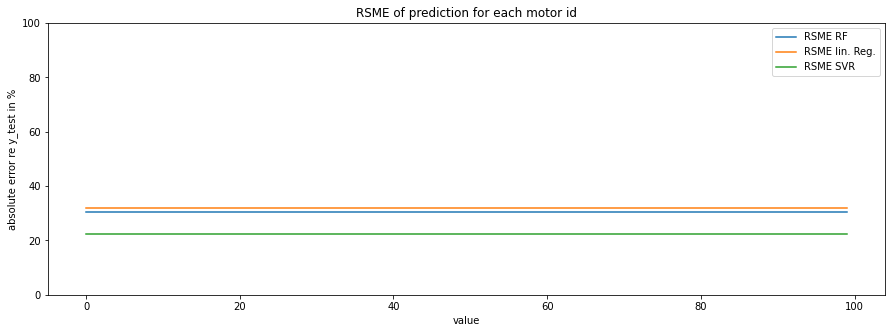

In [165]:
plt.figure(figsize=(15, 5))

plt.title('RSME of prediction for each motor id')
plt.legend(loc='upper right')

plt.ylim(0, 100)
plt.xlabel("value")
plt.ylabel('absolute error re y_test in %')
plt.plot(rsme_rf * np.ones(100))
plt.plot(rsme_reg * np.ones(100))
plt.plot(rsme_svr * np.ones(100))
plt.gca().legend(('RSME RF', 'RSME lin. Reg.', 'RSME SVR'))

No handles with labels found to put in legend.


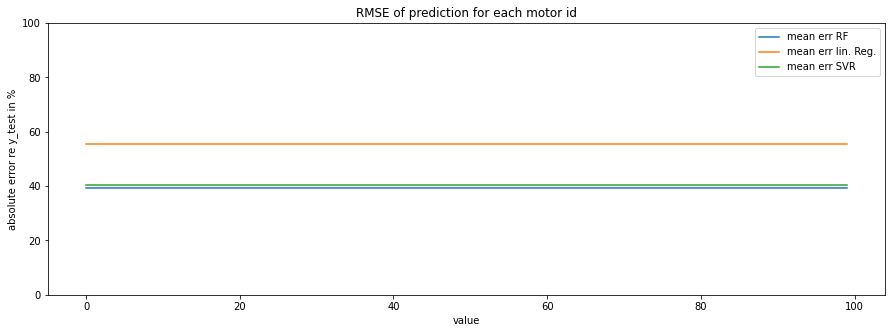

In [166]:
plt.figure(figsize=(15, 5))

plt.title('RMSE of prediction for each motor id')
plt.legend(loc='upper right')

plt.ylim(0, 100)
plt.xlabel("value")
plt.ylabel('absolute error re y_test in %')
plt.plot(np.mean(error_re_y_test_rf) * np.ones(100))
plt.plot(np.mean(error_re_y_test_reg) * np.ones(100))
plt.plot(np.mean(error_re_y_test_svr) * np.ones(100))
plt.gca().legend(('mean err RF', 'mean err lin. Reg.', 'mean err SVR'))

std linear regression: 65.65678240519964


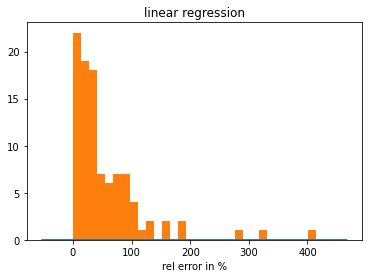

In [167]:
sns.distplot(error_re_y_test_reg, bins=30,axlabel='rel error in %').set_title('linear regression')
plt.hist(error_re_y_test_reg, bins=30)
print('std linear regression: ' + str(np.std(error_re_y_test_reg)))

std RF: 47.02543389108661


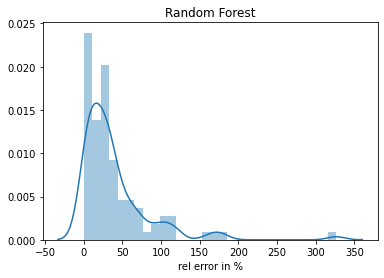

In [168]:
sns.distplot(error_re_y_test_rf, bins=30,axlabel='rel error in %').set_title('Random Forest')
print('std RF: ' + str(np.std(error_re_y_test_rf)))

std SVR: 53.64418347119265


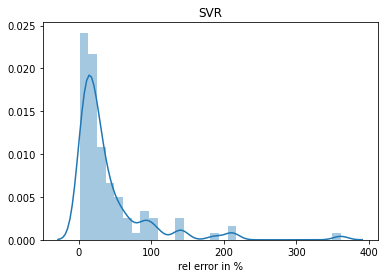

In [169]:
sns.distplot(error_re_y_test_svr, bins=30,axlabel='rel error in %').set_title('SVR')
print('std SVR: ' + str(np.std(error_re_y_test_svr)))

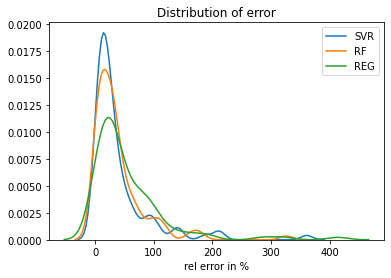

In [170]:
# all distplots in one plot
sns.distplot(error_re_y_test_svr, bins=30,axlabel='rel error in %', hist=False, label='SVR').set_title('Distribution of error')
sns.distplot(error_re_y_test_rf, bins=30,axlabel='rel error in %', hist=False, label='RF')
sns.distplot(error_re_y_test_reg, bins=30,axlabel='rel error in %', hist=False, label='REG')

# Classification models
The other method to predict the RUL is using classification models. In order to effectively use a classification method a proper feature has to be added. 
In this dataset, we classify if certain sensor values lead to a failure of a system. A failure is marked as 1, whereas a proper operation has 0 as its value. 
We also define a TTF (time to failure) time and a 'period' variable which defines the number of cycles left until RUL. 


In [171]:
# add TTL (time to failure) variable
train['TTF'] = train.groupby(['id'])['cycle'].transform(max)-train['cycle']
test['TTF'] = test.groupby(['id'])['cycle'].transform(max)-test['cycle']

period = 30

train['label_bc'] = train['TTF'].apply(lambda y: 1 if y <= period else 0)
test['label_bc'] = test['TTF'].apply(lambda y: 1 if y <= period else 0) 
train.tail()
test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,TTF,label_bc
0,1,1,0.0023,0.0003,100.0,518.67,0.545181,0.310661,0.269413,14.62,...,0.308965,0.03,0.333333,2388,100.0,0.558140,0.661834,142,30,1
1,1,2,-0.0027,-0.0003,100.0,518.67,0.150602,0.379551,0.222316,14.62,...,0.213159,0.03,0.416667,2388,100.0,0.682171,0.686827,141,29,1
2,1,3,0.0003,0.0001,100.0,518.67,0.376506,0.346632,0.322248,14.62,...,0.458638,0.03,0.416667,2388,100.0,0.728682,0.721348,140,28,1
3,1,4,0.0042,0.0000,100.0,518.67,0.370482,0.285154,0.408001,14.62,...,0.257022,0.03,0.250000,2388,100.0,0.666667,0.662110,139,27,1
4,1,5,0.0014,0.0000,100.0,518.67,0.391566,0.352082,0.332039,14.62,...,0.300885,0.03,0.166667,2388,100.0,0.658915,0.716377,138,26,1


In [172]:
# use np arrays as input data type
# train_labels = np.array(train['cycle'])   
# test_labels = np.array(test['cycle']) 
train_labels = train['label_bc']  
test_labels = test['label_bc']


# remove cycle from datasets
train_features = train.drop(['cycle', 'id', 'setting1', 'setting2', 'setting3', 'RUL', 'TTF', 'label_bc'], axis=1)    
test_features = test.drop(['cycle', 'id', 'setting1', 'setting2', 'setting3', 'RUL', 'TTF', 'label_bc'], axis=1)

feature_list = list(train_features.columns)

## check data sizes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

train_features.head()
test_features.head()
train_labels.head()
test_labels.head()

Training Features Shape: (20631, 21)
Training Labels Shape: (20631,)
Testing Features Shape: (13096, 21)
Testing Labels Shape: (13096,)


0    1
1    1
2    1
3    1
4    1
Name: label_bc, dtype: int64

## Random forest classifier model

In [173]:
rf_clas = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=15)

# fit model
rf_clas.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [174]:
# predictions
train_label_bc = np.array(train['label_bc'])   # predicting cycle
test_label_bc = np.array(test['label_bc']) 
predictions = rf_clas.predict(test_features)
errors = abs(predictions - test_labels)

# Print out the mean absolute error
print('Mean Absolute Error:', round(np.mean(errors), 2))    # cannot compare regression/classification errors 

Mean Absolute Error: 0.22


In [26]:
print('Accuracy of model on test data: ',accuracy_score(test_label_bc, predictions))
print('Confusion Matrix: \n',confusion_matrix(test_label_bc, predictions))
test.head()

NameError: name 'test_label_bc' is not defined

## KNN model

## Determining RUL 
The predictions result only in an array, which classifies if a certain set of sensor values qualifies as part of the class or not. 

<class 'pandas.core.frame.DataFrame'>
13096


,id,cycle,label_bc,failure
0,1,1,0,0.0
1,1,2,0,0.0
2,1,3,0,0.0
3,1,4,0,0.0
4,1,5,0,0.0


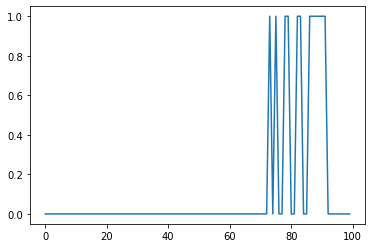

In [176]:
# plot prediction to get a better idea
prediction_data = test['id cycle'.split(' ')]
prediction_data['label_bc'] = predictions
# prediction_data['failure'] = 
# print(prediction_data['id'].max())
# print(len(prediction_data))
prediction_data['failure'] = np.zeros(len(prediction_data))

# print(prediction_data['id'][0])
# print(prediction_data['cycle'][13000])
# print(y_test['RUL'][currentID])
# print(prediction_data['failure'][13000])

# for i in range(0, 12999):
#     currentID = prediction_data['id'][i] - 1
#     if prediction_data['cycle'][i] == y_test['RUL'][currentID]:
#         prediction_data['failure'][i] = 1

print(type(prediction_data))
plt.plot(predictions[4500:4600])
# plt.plot(predictions)
# prediction_data.head()
y_test.head()
print(len(prediction_data))
# prediction_data['id'][400]
prediction_data.head()